In [92]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
import h5py
from tqdm import tqdm
from peft import LoraConfig, get_peft_model
from aion.model import AION
from aion.codecs import CodecManager
from aion.modalities import LegacySurveyImage
from aion.modalities import (
    LegacySurveyImage,
    DESISpectrum,
    LegacySurveyFluxG,
    LegacySurveyFluxR,
    LegacySurveyFluxI,
    LegacySurveyFluxZ,
    Z,
)
# Configuration

LEARNING_RATE = 1e-4
NUM_WORKERS = 4
NSAMPLES = 5000
SEED = 42
device = 'cuda:0'

# Load data
test_file = h5py.File('../chto/astrofm/semi_supervised_only_tq_train_i_snr_20_32bit.hdf5', 'r+')

from matplotlib import colors
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
plt.style.use("MNRAS_Style")


In [38]:
test_file.keys()

<KeysViewHDF5 ['decs', 'ebvs', 'features', 'features_dr', 'images', 'mags', 'mags_dr', 'objectId', 'ras', 'redshifts', 'use_redshift_1']>

In [54]:
images.shape

(6615, 4, 108, 108)

In [55]:
fluxes.shape

(6615, 4)

In [57]:

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, images, flux, labels):
        self.images = images
        self.fluxes = flux
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.fluxes[idx], self.labels[idx]

# Create splits
labels = test_file['redshifts'][:].astype(np.float32)
images = test_file['images'][:, 1:5, :, :].astype('float32')
fluxes = 10**((test_file['mags'][:,1:5]-22.5)/2.5).astype('float32')
rng = np.random.default_rng(SEED)
random_idxs = rng.choice(len(labels), len(labels), replace=False)

train_images = images[random_idxs[:NSAMPLES]]
train_flux = fluxes[random_idxs[:NSAMPLES]]
train_labels = labels[random_idxs[:NSAMPLES]]
val_images = images[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]
val_flux = fluxes[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]

val_labels = labels[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]
test_images = images[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]
test_flux = fluxes[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]
test_labels = labels[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]

train_dataset = SequenceDataset(train_images, train_flux,train_labels)
val_dataset = SequenceDataset(val_images, val_flux, val_labels)
test_dataset = SequenceDataset(test_images, test_flux, test_labels)

print(f"✓ Data split created:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples\n")


✓ Data split created:
  Train: 5,000 samples
  Val: 500 samples
  Test: 500 samples



In [58]:

# Initialize codec manager
codec_manager = CodecManager(device="cuda:0")

# Load base model
print("Loading AION base model...")
model = AION.from_pretrained("polymathic-ai/aion-base")

# Configure LoRA
lora_config = LoraConfig(
    r=40, # Reduced from 10 for less memory
    lora_alpha=32,
    target_modules=["q", "proj"],
    lora_dropout=0.1,
    bias="none",
)

print("Applying LoRA adapters...")
ft_model = get_peft_model(model, lora_config)


Loading AION base model...
Applying LoRA adapters...


In [68]:

# Custom regression model with proper multi-GPU support
class RegressionModel(nn.Module):
    def __init__(self, base_model, codec_manager):
        super().__init__()
        self.base_model = base_model
        self.codec_manager = codec_manager
        self.regressor = nn.Linear(768, 1)
    
    def forward(self, inputs, inputs2):
        # Encode on single GPU to avoid redundant encoding
        with torch.no_grad():
            inputs_encoded = self.codec_manager.encode(
                LegacySurveyImage(
                    flux=inputs.to('cuda:0'), 
                    bands=["DES-G", "DES-R", "DES-I", "DES-Z"]
                ),
                LegacySurveyFluxG(value=inputs2[:,0].to('cuda:0')),
                LegacySurveyFluxR(value=inputs2[:,1].to('cuda:0')),
                LegacySurveyFluxI(value=inputs2[:,2].to('cuda:0')),
                LegacySurveyFluxZ(value=inputs2[:,3].to('cuda:0')),
            )
        
        # Move to appropriate device for model
        inputs_encoded = {k: v.to(inputs.device) for k, v in inputs_encoded.items()}
        
        # Encode through AION
        outputs = self.base_model.encode(inputs_encoded, num_encoder_tokens=900)
        pooled_output = outputs.mean(dim=1)
        
        return self.regressor(pooled_output).squeeze(-1)

# Create model and wrap with DataParallel
regression_model = RegressionModel(ft_model, codec_manager)
#regression_model = nn.DataParallel(regression_model, device_ids=[0, 1, 2, 3])
regression_model = regression_model.to(device)


In [69]:

def print_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_params:,}")
    print(f"  Trainable: {100 * trainable_params / all_params:.2f}%")

print("\n🎯 Model Architecture:")
print("-" * 60)
print_trainable_parameters(regression_model)
print("-" * 60)



🎯 Model Architecture:
------------------------------------------------------------
  Trainable params: 2,949,889
  Total params: 317,205,505
  Trainable: 0.93%
------------------------------------------------------------


In [100]:
BATCH_SIZE = 128  # Reduced from 200 - adjust based on your GPU memory
NUM_EPOCHS = 500
LEARNING_RATE = 1e-4

In [101]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS)

# Setup optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), 
                 lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n✓ Model and data loaders ready!\n")

# Training loop
print("🚀 STARTING LORA FINE-TUNING")
print("=" * 70)


✓ Model and data loaders ready!

🚀 STARTING LORA FINE-TUNING


In [102]:
device='cuda:0'

In [106]:


best_val_loss = float('inf')

for ep in range(NUM_EPOCHS):
    # Training
    regression_model.train()
    train_loss_sum = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]")
    for inputs, input2, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        input2=input2.to(device)
        
        optimizer.zero_grad()
        
        try:
            preds = regression_model(inputs,input2)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\n⚠️  OOM Error - Skipping batch. Consider reducing batch size.")
                torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    avg_train_loss = train_loss_sum / len(train_loader)
    
    # Validation
    regression_model.eval()
    val_loss_sum = 0.0
    
    with torch.no_grad():
        for inputs, inputs2, labels in tqdm(val_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Val]", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs2 = inputs2.to(device)
            preds = regression_model(inputs,inputs2)
            loss = loss_fn(preds, labels)
            val_loss_sum += loss.item()
    
    avg_val_loss = val_loss_sum / len(val_loader)
    
    print(f"Epoch {ep+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(regression_model.state_dict(), 'best_model2.pt')
        print(f"  ✓ Saved best model (val_loss: {best_val_loss:.4f})")
    
    # Clear cache periodically
    if (ep + 1) % 10 == 0:
        torch.cuda.empty_cache()

print("\n" + "=" * 70)
print("✓ Fine-tuning complete!")
print("=" * 70)

# Test evaluation


Epoch 2/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.31s/it, loss=0.0146]
                                                                                                                                                                                                                              

Epoch 2/500 - Train Loss: 0.1125, Val Loss: 0.2012
  ✓ Saved best model (val_loss: 0.2012)


Epoch 3/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.30s/it, loss=0.0540]
                                                                                                                                                                                                                              

Epoch 3/500 - Train Loss: 0.1082, Val Loss: 0.2009
  ✓ Saved best model (val_loss: 0.2009)


Epoch 4/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.30s/it, loss=0.1301]
                                                                                                                                                                                                                              

Epoch 4/500 - Train Loss: 0.1043, Val Loss: 0.2079


Epoch 5/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.30s/it, loss=0.0312]
                                                                                                                                                                                                                              

Epoch 5/500 - Train Loss: 0.1003, Val Loss: 0.2054


Epoch 6/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.1783]
                                                                                                                                                                                                                              

Epoch 6/500 - Train Loss: 0.1018, Val Loss: 0.2049


Epoch 7/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.1591]
                                                                                                                                                                                                                              

Epoch 7/500 - Train Loss: 0.1052, Val Loss: 0.2098


Epoch 8/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0707]
                                                                                                                                                                                                                              

Epoch 8/500 - Train Loss: 0.0953, Val Loss: 0.2090


Epoch 9/500 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.1485]
                                                                                                                                                                                                                              

Epoch 9/500 - Train Loss: 0.0925, Val Loss: 0.2175


Epoch 10/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0590]
                                                                                                                                                                                                                              

Epoch 10/500 - Train Loss: 0.0875, Val Loss: 0.2058


Epoch 11/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0417]
                                                                                                                                                                                                                              

Epoch 11/500 - Train Loss: 0.0825, Val Loss: 0.2075


Epoch 12/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0374]
                                                                                                                                                                                                                              

Epoch 12/500 - Train Loss: 0.0847, Val Loss: 0.2090


Epoch 13/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0394]
                                                                                                                                                                                                                              

Epoch 13/500 - Train Loss: 0.0779, Val Loss: 0.2189


Epoch 14/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0632]
                                                                                                                                                                                                                              

Epoch 14/500 - Train Loss: 0.0776, Val Loss: 0.1953
  ✓ Saved best model (val_loss: 0.1953)


Epoch 15/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0222]
                                                                                                                                                                                                                              

Epoch 15/500 - Train Loss: 0.0760, Val Loss: 0.2043


Epoch 16/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.1591]
                                                                                                                                                                                                                              

Epoch 16/500 - Train Loss: 0.0765, Val Loss: 0.1862
  ✓ Saved best model (val_loss: 0.1862)


Epoch 17/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0692]
                                                                                                                                                                                                                              

Epoch 17/500 - Train Loss: 0.0728, Val Loss: 0.1985


Epoch 18/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0105]
                                                                                                                                                                                                                              

Epoch 18/500 - Train Loss: 0.0669, Val Loss: 0.2076


Epoch 19/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0963]
                                                                                                                                                                                                                              

Epoch 19/500 - Train Loss: 0.0691, Val Loss: 0.2112


Epoch 20/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0351]
                                                                                                                                                                                                                              

Epoch 20/500 - Train Loss: 0.0656, Val Loss: 0.2189


Epoch 21/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0343]
                                                                                                                                                                                                                              

Epoch 21/500 - Train Loss: 0.0638, Val Loss: 0.2016


Epoch 22/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0512]
                                                                                                                                                                                                                              

Epoch 22/500 - Train Loss: 0.0646, Val Loss: 0.2054


Epoch 23/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0551]
                                                                                                                                                                                                                              

Epoch 23/500 - Train Loss: 0.0612, Val Loss: 0.2114


Epoch 24/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0501]
                                                                                                                                                                                                                              

Epoch 24/500 - Train Loss: 0.0605, Val Loss: 0.2308


Epoch 25/500 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.29s/it, loss=0.0238]
                                                                                                                                                                                                                              

Epoch 25/500 - Train Loss: 0.0574, Val Loss: 0.2093


Epoch 26/500 [Train]:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 29/40 [00:39<00:15,  1.37s/it, loss=0.0484]


KeyboardInterrupt: 

In [113]:
#To load best fit model
#regression_model.load_state_dict(torch.load("./best_model.pt", weights_only=True))


In [108]:
# Evaluate on test set
print("🔄 Evaluating on test set...\n")
regression_model.eval()
test_predictions = []
labels_all = []
for inputs, inputs2, labels in tqdm(val, desc="Testing"):
    with torch.no_grad():
        preds = regression_model(inputs, inputs2).cpu().numpy()
        test_predictions.extend(preds)
        labels_all.extend(labels)
test_predictions = np.array(test_predictions)


🔄 Evaluating on test set...



Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  1.52it/s]


(0.0, 3.0)

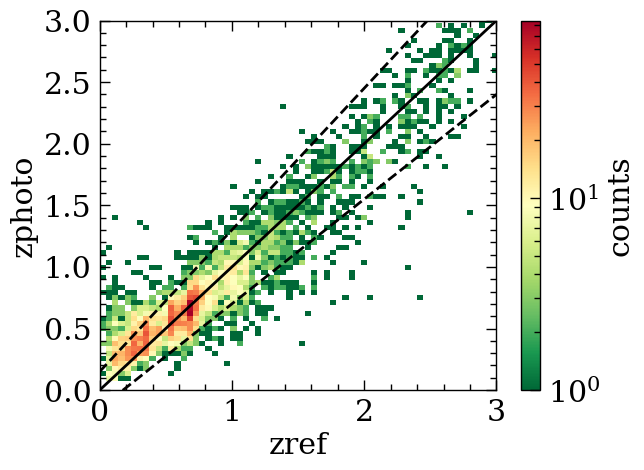

In [109]:

fig,ax = plt.subplots()
h = plt.hist2d(labels_all, test_predictions,
           bins = 100, 
           cmap = "RdYlGn_r",
           norm = colors.LogNorm())
cbar = fig.colorbar(h[3], ax=ax)
cbar.ax.set_ylabel("counts")
plt.plot(np.linspace(0,3,10), np.linspace(0,3,10), c='k')
plt.plot(np.linspace(0,3,10), (1+np.linspace(0,3,10))*0.15+np.linspace(0,3,10), c='k', ls="--")
plt.plot(np.linspace(0,3,10),  -1*(1+np.linspace(0,3,10))*0.15+np.linspace(0,3,10), c='k', ls="--")
plt.xlabel("zref")
plt.ylabel("zphoto")
plt.xlim(0,3)
plt.ylim(0,3)

In [110]:
def calculate_stats(y, y_pred, outlier_f=0.15):
    delta = (y_pred - y)/(1+y)
    bias = np.mean(delta)
    nmad = 1.4826*np.median(np.abs(delta - np.median(delta)))
    outlier_fraction = np.sum(np.abs(delta)>outlier_f)/len(y)
    nmad_err = nmad/np.sqrt(2*len(y))
    outlier_f_error = np.sqrt(outlier_fraction*(1-outlier_fraction)/len(y))
    return bias, nmad, outlier_fraction, nmad_err, outlier_f_error


In [112]:
calculate_stats(np.array(labels_all), test_predictions)

(np.float32(0.024597041),
 np.float32(0.09554821),
 np.float64(0.1704),
 np.float64(0.0009554821252822876),
 np.float64(0.005317214308263303))

In [64]:
test_file = h5py.File('../chto/astrofm/semi_supervised_only_tq_train_i_snr_20_32bit.hdf5', 'r+')


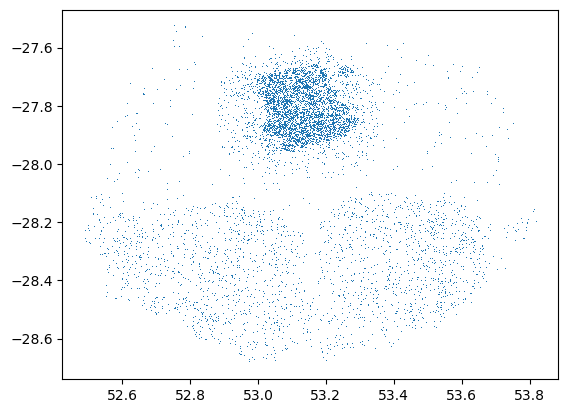

In [67]:
plt.plot(test_file['ras'][:],test_file['decs'][:],",")